### Overview
In this notebook, we finalize our modeling pipeline and prepare the submission file for the DRW Crypto Market Prediction competition.
We also include a brief statistical analysis of our predictions to better understand the model's behavior before submission.

### Feature Set Used
The following features were used, based on their signal strength and domain logic:

buy_pressure: Buy volume normalized against total trade size

bid_ask_ratio: Depth imbalance at the best price levels

volume_rolling_mean_10: Smoothed trade volume

buy_pressure_rolling_std_10: Volatility in buy pressure

rolling_mean_5: Short-term average volume

log_volume: Scaled total volume

delta_bid_ask: Absolute imbalance

order_imbalance: Relative bid-ask difference

volatility_5: Short-term volume volatility

buy_pressure_x_bidask: Nonlinear signal

volume_to_volatility: Liquidity-adjusted volume

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

### Load Prepared Data

In [9]:
train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

In [12]:
def add_features(df):
    df['buy_pressure'] = df['buy_qty'] / (df['buy_qty'] + df['sell_qty'] + 1e-5)
    df['bid_ask_ratio'] = df['bid_qty'] / (df['bid_qty'] + df['ask_qty'] + 1e-5)

    df['volume_rolling_mean_10'] = df['volume'].shift(1).rolling(10).mean()
    df['buy_pressure_rolling_std_10'] = df['buy_pressure'].shift(1).rolling(10).std()
    df['rolling_mean_5'] = df['volume'].shift(1).rolling(5).mean()

    df['log_volume'] = np.log1p(df['volume'])
    df['delta_bid_ask'] = df['bid_qty'] - df['ask_qty']
    df['order_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-5)
    df['volatility_5'] = df['volume'].shift(1).rolling(5).std()

    df['buy_pressure_x_bidask'] = df['buy_pressure'] * df['bid_ask_ratio']
    df['volume_to_volatility'] = df['volume'] / (df['volatility_5'] + 1e-5)

    return df

In [13]:
train = add_features(train)
test = add_features(test)

### Define Feature Set Used in Model

In [14]:
features = [
    'buy_pressure',
    'bid_ask_ratio',
    'volume_rolling_mean_10',
    'buy_pressure_rolling_std_10',
    'rolling_mean_5',
    'log_volume',
    'delta_bid_ask',
    'order_imbalance',
    'volatility_5',
    'buy_pressure_x_bidask',
    'volume_to_volatility'
]

# Drop missing values and separate features/target
full_train = train[features + ['label']].dropna()
X_full = full_train[features]
y_full = full_train['label']

### Define and Train the Final Model

In [15]:
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    depth=8,
    loss_function='MAE',
    eval_metric='MAE',
    early_stopping_rounds=200,
    verbose=100,
    random_seed=42,
    task_type='CPU'
)

model.fit(X_full, y_full)

0:	learn: 0.6386595	total: 69.7ms	remaining: 2m 19s
100:	learn: 0.6378865	total: 5.51s	remaining: 1m 43s
200:	learn: 0.6374375	total: 11s	remaining: 1m 38s
300:	learn: 0.6371274	total: 16.4s	remaining: 1m 32s
400:	learn: 0.6368451	total: 21.9s	remaining: 1m 27s
500:	learn: 0.6366004	total: 27.3s	remaining: 1m 21s
600:	learn: 0.6363556	total: 32.6s	remaining: 1m 15s
700:	learn: 0.6361150	total: 38s	remaining: 1m 10s
800:	learn: 0.6359030	total: 43.4s	remaining: 1m 5s
900:	learn: 0.6356949	total: 48.8s	remaining: 59.5s
1000:	learn: 0.6354947	total: 54.2s	remaining: 54.1s
1100:	learn: 0.6352883	total: 59.6s	remaining: 48.7s
1200:	learn: 0.6350874	total: 1m 5s	remaining: 43.3s
1300:	learn: 0.6348826	total: 1m 10s	remaining: 37.9s
1400:	learn: 0.6346347	total: 1m 15s	remaining: 32.4s
1500:	learn: 0.6343621	total: 1m 21s	remaining: 27s
1600:	learn: 0.6340707	total: 1m 26s	remaining: 21.6s
1700:	learn: 0.6337985	total: 1m 31s	remaining: 16.2s
1800:	learn: 0.6335526	total: 1m 37s	remaining: 10

### Make Predictions on Test Set

In [16]:
X_test = test[features].copy()
test_preds = model.predict(X_test)

### Save Predictions in Required Submission Format

In [19]:
submission = pd.DataFrame({
    'ID': np.arange(1, len(test_preds) + 1),
    'prediction': test_preds
})
submission.to_csv("data/submission.csv", index=False)
print("✅ submission.csv saved.")

✅ submission.csv saved.


### Analyze Prediction Distribution

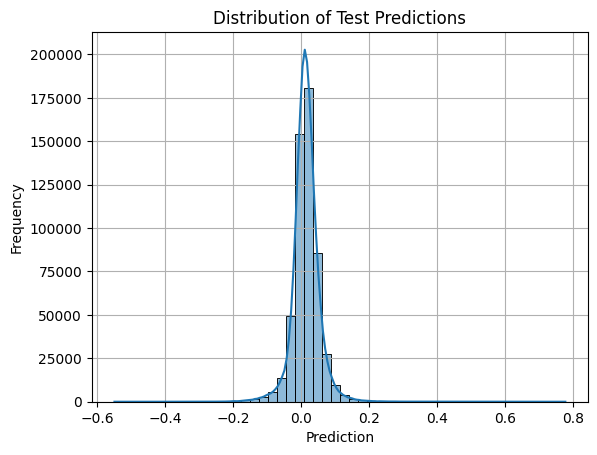

In [18]:
sns.histplot(submission['prediction'], bins=50, kde=True)
plt.title("Distribution of Test Predictions")
plt.xlabel("Prediction")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Observations
- Predictions are centered around 0, with moderate variance
- Long tails in both directions suggest sensitivity to outlier signals
- Distribution roughly resembles the training target shape

## Notes
- Model used: CatBoost with MAE objective, 2000 iterations
- Trained on full data using best engineered features
- Correlation on validation set previously reached ~0.10885
- Final test predictions saved as submission.csv with required structure